###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP
from littlegrad2.engine import Tensor

In [3]:
np.random.seed(1337)
random.seed(1337)

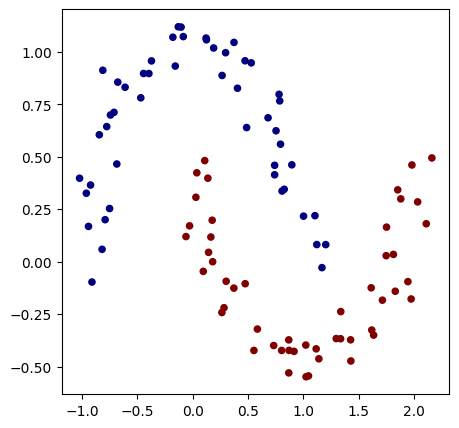

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

#y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
class LinearNet:
    def __init__(self):
        self.params = {
            'w1' : Tensor(2 * np.random.random_sample((2, 25)) - 1),
            'b1' : Tensor(np.zeros((1, 25))),
            'w2' : Tensor(2 * np.random.random_sample((25, 15)) - 1),
            'b2' : Tensor(np.zeros((1, 15))),
            'w3' : Tensor(2 * np.random.random_sample((15, 2)) - 1),
            'b3' : Tensor(np.zeros((1, 2)))

            #'f1' : Tensor(2 * np.random.random_sample((5, 5)) - 1),
            #'f2' : Tensor(2 * np.random.random_sample((5, 5)) - 1),
        }

    def parameters(self):
        return self.params.values()
    
    def zero_grad(self):
        for param in self.params.values():
            param.grad.fill(0)
            
    def __call__(self, x:Tensor) -> Tensor:
        return ((x@self.params['w1']+self.params['b1']).relu()@self.params['w2']+self.params['b2']).relu()@self.params['w3']+self.params['b3']

model = LinearNet()
print(model.params)

{'w1': Tensor object with data [[-0.09473641 -0.95590983 -0.58236061  0.22658235  0.85611212  0.20849793
   0.12288683 -0.17135192  0.67174713  0.16254652  0.48923736 -0.50848202
  -0.77118174  0.97955573 -0.93483169 -0.55703395 -0.16943475 -0.52146185
  -0.46902788  0.1115221   0.21990278  0.21350836  0.52291437 -0.56943861
   0.78714387]
 [ 0.32074548 -0.90951803  0.19376769 -0.24523819 -0.31139538 -0.60247814
   0.43083838  0.95459472 -0.44428741  0.31098826 -0.12552534 -0.13371708
  -0.78850897 -0.49699903  0.73633136 -0.76825152 -0.36688302  0.4297614
  -0.2411271  -0.45909155  0.89380712  0.82001894  0.22053685  0.99233245
   0.97319907]], 'b1': Tensor object with data [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]], 'w2': Tensor object with data [[ 0.75591099  0.00295168  0.62330533  0.59180552 -0.6448284   0.2148248
  -0.8042436  -0.54235785 -0.71351615 -0.38086553 -0.09313641 -0.40723726
   0.11901711  0.74357442 -0.58584529]
 [-0.88479849  0.8

In [6]:
def softmax(logits):
  counts = logits.exp()
  denominator = counts @ np.ones(shape = (counts.data.size, counts.data.size)) #2D ones matrix avoids denom broadcasting which fucks up gradient shape
  return counts / denominator, logits - denominator.log() #probs, log_softmax

#X = (X-np.average(X)) / np.std(X)  #data normalization
def loss(X, y, model, batch_size=None):

    if batch_size is None:  #dataloader
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] #shuffles the X indexes and returns the first 10
        Xb, yb = X[ri], y[ri]

    losses, accuracy = [], []
    for (xrow, yrow) in zip(Xb, yb):
        probs, log_softmax = softmax(model(Tensor(xrow)))        
        losses.append(-log_softmax @ Tensor([index == yrow for index in range(log_softmax.data.size)]).transpose())
        # ^ cross entropy loss (can't just take log_softmax[yrow] or else you lose track of gradients and backward() doesn't work)
        accuracy.append(yrow == np.argmax(probs.data))

    # L2 regularization
    alpha = 0.0033
    reg_loss = alpha * sum([p.flatten()@p.flatten().transpose() for p in model.parameters()])
    return np.average(losses) + reg_loss, np.average(accuracy) # (total_loss = data_loss + reg_loss)


In [7]:
learning_rate, beta1, beta2, epsilon, weight_decay = 0.00058, 0.9, 0.999, 1e-10, 0.05
# optimization
for k in range(200):
    
    # forward
    total_loss, acc = loss(X, y, model)

    # backward
    model.zero_grad()
    total_loss.backprop()
    
    #update parameters w/ AdamW Algorithm
    for p in model.parameters(): 
        p.data -= p.data * learning_rate * weight_decay
        p.v = (beta1 * p.v) + ((1-beta1) * p.grad)
        p.s = (beta2 * p.s) + ((1-beta2) * p.grad * p.grad)
        v_dp_corrected = p.v / (1 - (beta1**(k+1)))
        s_dp_corrected = p.s / (1 - (beta2**(k+1)))
        p.data -= learning_rate * v_dp_corrected / (np.sqrt(s_dp_corrected) + epsilon)
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss [[1.07580523]], accuracy 52.0%
step 1 loss [[1.06352397]], accuracy 56.00000000000001%
step 2 loss [[1.05176263]], accuracy 57.99999999999999%
step 3 loss [[1.04058115]], accuracy 57.99999999999999%
step 4 loss [[1.02990762]], accuracy 59.0%
step 5 loss [[1.01968188]], accuracy 62.0%
step 6 loss [[1.00989164]], accuracy 68.0%
step 7 loss [[1.0004788]], accuracy 71.0%
step 8 loss [[0.99143387]], accuracy 76.0%
step 9 loss [[0.98279856]], accuracy 78.0%
step 10 loss [[0.97457169]], accuracy 81.0%
step 11 loss [[0.96669358]], accuracy 82.0%
step 12 loss [[0.95910365]], accuracy 83.0%
step 13 loss [[0.95180618]], accuracy 83.0%
step 14 loss [[0.94482049]], accuracy 83.0%
step 15 loss [[0.9380943]], accuracy 83.0%
step 16 loss [[0.93163167]], accuracy 83.0%
step 17 loss [[0.92543413]], accuracy 83.0%
step 18 loss [[0.91953906]], accuracy 83.0%
step 19 loss [[0.91384955]], accuracy 83.0%
step 20 loss [[0.90834096]], accuracy 83.0%
step 21 loss [[0.90306978]], accuracy 83.0%
step 

(-1.548639298268643, 1.951360701731357)

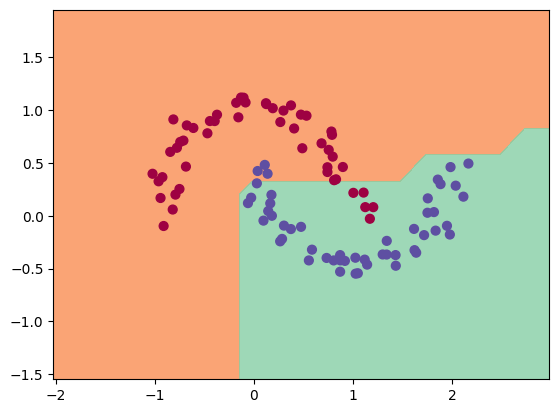

In [8]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#scores = list(map(model, inputs))
#scores = list(map(model, [Tensor(xi) for xi in Xmesh]))
scores = []
for xrow in Xmesh:
    probs, log_softmax = softmax(model(Tensor(xrow)))
    scores.append(np.argmax(probs.data))

#Z = np.array([s.data > 0 for s in scores])
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


In [9]:
a = np.arange(120).reshape((2, 3, 4, 5))
print(a)

[[[[  0   1   2   3   4]
   [  5   6   7   8   9]
   [ 10  11  12  13  14]
   [ 15  16  17  18  19]]

  [[ 20  21  22  23  24]
   [ 25  26  27  28  29]
   [ 30  31  32  33  34]
   [ 35  36  37  38  39]]

  [[ 40  41  42  43  44]
   [ 45  46  47  48  49]
   [ 50  51  52  53  54]
   [ 55  56  57  58  59]]]


 [[[ 60  61  62  63  64]
   [ 65  66  67  68  69]
   [ 70  71  72  73  74]
   [ 75  76  77  78  79]]

  [[ 80  81  82  83  84]
   [ 85  86  87  88  89]
   [ 90  91  92  93  94]
   [ 95  96  97  98  99]]

  [[100 101 102 103 104]
   [105 106 107 108 109]
   [110 111 112 113 114]
   [115 116 117 118 119]]]]


In [10]:
# b = np.arange(120).reshape(2, 5, 4, 3)
# print(a.shape)
# print(b.shape)
# print(a@b)

In [11]:
test = np.arange(12).reshape(3, 4)
print(test)
poop = slice(1, -1), slice(1, 3)
print(poop)
print(test[poop])
grad = np.array([10, 10])
cringe = test[poop]
cringe *= grad
print(test)

# poop = np.array([[0, 1, 0, 0, 0]]).T
# print(test.shape)
# print(poop.shape)
#print(test)
#test = test.reshape(2, 3, 4, 5)
# out = (test@poop).reshape(2, 3, 4, 1)
#print(test)
# print(out)
# print(out.shape)

# test = np.arange(24).reshape(2, 12)
# print(test)
# test = test.reshape(2, 3, 4)
# print(test)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
(slice(1, -1, None), slice(1, 3, None))
[[5 6]]
[[ 0  1  2  3]
 [ 4 50 60  7]
 [ 8  9 10 11]]


In [12]:
test = np.arange(12).reshape(3, 4)
print(test)

f = 2
#poop = np.ndarray(shape = (test.shape[0]-f, test.shape[1]-f))
poop = []
for x in range(test.shape[0]-f+1):
    for y in range(test.shape[1]-f+1):
        #poop[x, y] = test[slice(x, x+f), slice(y, y+f)]
        poop.append(test[slice(x, x+f), slice(y, y+f)])

poop = np.array(poop)*10
# poop = np.array([[slice(1, -1), slice(1, 3)]])
# print('poop: ', poop)
# grad = np.array([[10, 10]])
# print('test[poop[0, 0]]: ', test[poop[0, 0]])
# cringe = np.array([[test[poo] for poo in poop[0]]])
# print(cringe)
# neugh = np.ones(shape=())
# print(neugh)
# cringe *= neugh
#cringe *= grad
print(test)
for poo in poop:
    print(poo)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0 10]
 [40 50]]
[[10 20]
 [50 60]]
[[20 30]
 [60 70]]
[[40 50]
 [80 90]]
[[ 50  60]
 [ 90 100]]
[[ 60  70]
 [100 110]]


In [13]:
N = 3
k, n = np.arange(N).reshape((1, -1, 1)), np.arange(N).reshape((-1, 1, 1))
test = n @ k
print(np.exp(test* 2 * np.pi * -1j / N))
test = np.exp(np.arange(N).reshape((-1, 1)) @ np.arange(N).reshape((1, -1)))
print(test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [21]:
test = np.arange(120).reshape((1, 2, 3, 4, 5))
print(test)
print(test.reshape((5, -1)).reshape((1, 2, 3, 4, 5)))

[[[[[  0   1   2   3   4]
    [  5   6   7   8   9]
    [ 10  11  12  13  14]
    [ 15  16  17  18  19]]

   [[ 20  21  22  23  24]
    [ 25  26  27  28  29]
    [ 30  31  32  33  34]
    [ 35  36  37  38  39]]

   [[ 40  41  42  43  44]
    [ 45  46  47  48  49]
    [ 50  51  52  53  54]
    [ 55  56  57  58  59]]]


  [[[ 60  61  62  63  64]
    [ 65  66  67  68  69]
    [ 70  71  72  73  74]
    [ 75  76  77  78  79]]

   [[ 80  81  82  83  84]
    [ 85  86  87  88  89]
    [ 90  91  92  93  94]
    [ 95  96  97  98  99]]

   [[100 101 102 103 104]
    [105 106 107 108 109]
    [110 111 112 113 114]
    [115 116 117 118 119]]]]]
[[[[[  0   1   2   3   4]
    [  5   6   7   8   9]
    [ 10  11  12  13  14]
    [ 15  16  17  18  19]]

   [[ 20  21  22  23  24]
    [ 25  26  27  28  29]
    [ 30  31  32  33  34]
    [ 35  36  37  38  39]]

   [[ 40  41  42  43  44]
    [ 45  46  47  48  49]
    [ 50  51  52  53  54]
    [ 55  56  57  58  59]]]


  [[[ 60  61  62  63  64]
    [ 65  66  